# Imperfect tests

This model includes the sensitivity and specificity of the diagnostic test. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta,  \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\    
  \end{aligned}  
\end{equation}

where $a^p, a^s, a^e, b^p, b^s, b^e \in \mathbb{R}_{++}$ are fixed hyperparameters.
This model does not include prior knowledge about the correlation between specificity and sensitivity. 


In [1]:
import numpy as np
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan code 

Below we can see the code written in Stan. 

In [6]:
compiled = False
#compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/imperfect_test.stan')
    with open('../models/primary_model/pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_946cae1088beaa2819728bd4f0169e99 NOW.


Below wee see the required data and transformed data. 

In [8]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int Y[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
}
transformed data {
   matrix[n_predictors, n_predictors] sigma; 
   sigma = cholesky_decompose(Sigma);
}


And now the model and parameters

In [12]:
print(structure[2] + '}' + structure[3]+'}' + structure[4]+'}'+ structure[5]+'}') 


parameters {
    vector[n_predictors] normal_raw; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
}
transformed parameters {
    vector[n_samples] p; 
    vector[n_predictors] effects; 
    effects = mu + sigma * normal_raw;
    p = (1 - spec) + (spec + sens - 1) * inv_logit(logit(prev) + x * effects);
}
model {
    normal_raw ~ std_normal();
    prev ~ beta(alpha_p, beta_p);
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);
    Y ~ bernoulli(p);
}
generated quantities {
    vector[n_samples] theta;
    theta = inv_logit(logit(prev) + x * effects);
}


## Identifiability

In [13]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples)

# Normalization
x = (x - x.mean(axis=0))/x.std(axis = 0, ddof = 1)

Note that we generate $x$ in the same way as for perfect tests model tests. 

In [36]:
# Parameters we want to estimate
spec = 0.85
sens = 0.8

beta = np.array([0.1, 1.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1

# Generated quantities

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T  = ro.binomial(n = 1, p = p)

# Hyperparameters to the estimation process
alpha_s = 1
beta_s  = 1
alpha_e = 1
beta_e  = 1
alpha_p = 1
beta_p  = 1
Sigma   = np.eye(5)
mu      = np.zeros(5)

# Data for the Stan code
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "Y"            : T.flatten(),
    "x"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
}

T.mean()

0.295

How the numerical part of the problem enters the picture

In [38]:
%%time
fit_imperfect = sm.sampling(data=data, pars = ('prev', 'effects', 'spec', 'sens'), iter=8000)
summary = az.summary(fit_imperfect)

CPU times: user 345 ms, sys: 47.9 ms, total: 393 ms
Wall time: 7.06 s


Notice the very bad plots. 

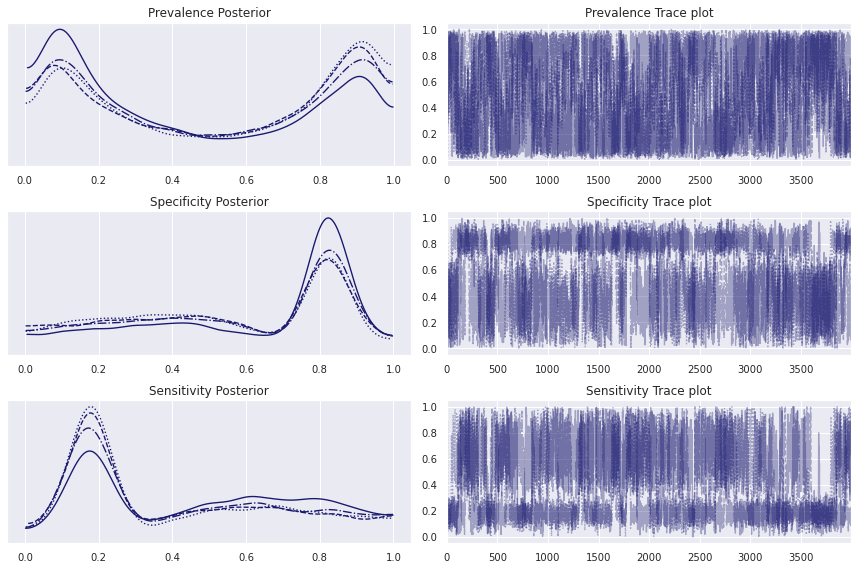

In [86]:
fig, ax = plt.subplots(3,2, figsize = (12, 8))
az.plot_trace(fit_imperfect, var_names=['prev', 'spec', 'sens'],
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', '-.', ':']},
              axes = ax
             )
ax[0,0].set_title('Prevalence Posterior')
ax[1,0].set_title('Specificity Posterior')
ax[2,0].set_title('Sensitivity Posterior')
ax[0,1].set_title('Prevalence Trace plot')
ax[1,1].set_title('Specificity Trace plot')
ax[2,1].set_title('Sensitivity Trace plot')
fig.tight_layout(pad = 1)
plt.savefig('../images/posterior-trace-imperfect-tests-identifiability.pdf', bbox_inches='tight')
plt.show()

Note that the prior of $\theta$ is very sharp after $\theta > 0.6$ and that is
very strange...

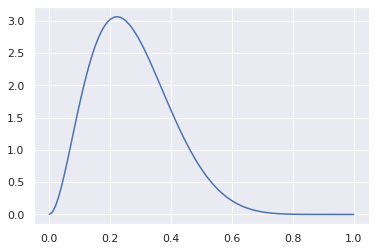

In [12]:
from scipy.stats import beta

t = np.linspace(0,1,100)
x = beta(a = alpha_p, b = alpha_e).pdf(t)

plt.plot(t,x)
plt.show()

In order to verify why it happened, we tested with another $T$ (array with
positive or negative tests for each individual) and the problem was missing. 

In [13]:
%%time
T2 = ro.binomial(n = 1, p = p)
data['T'] = T2.flatten()
fit_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_imperfect)

CPU times: user 7.35 s, sys: 276 ms, total: 7.63 s
Wall time: 14.5 s


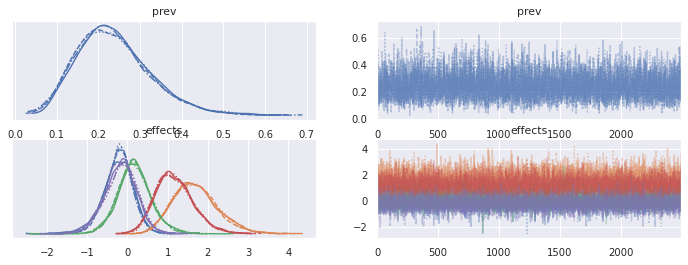

In [14]:
az.plot_trace(fit_imperfect, var_names=('prev', 'effects'))
plt.show()

Why? The means and vars are so close...

In [15]:
print(T.mean())
print(T2.mean())
print(T.var())
print(T2.var())

0.31
0.32
0.21389999999999998
0.21759999999999993


### Sanity check

We already know that $\theta_i$ is linear on $p_i$. Let's check this getting
the estimated means for $\theta$ and $p$ among the individuals. 

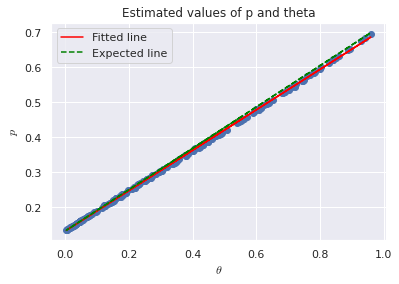

In [16]:
theta_values = summary[summary.index.str.contains('theta')]['mean']
p_values = summary[summary.index.str.contains('p\[')]['mean']

line_parameters = np.polyfit(theta_values, p_values, deg = 1)

spec_hat = summary.loc['spec', 'mean']
sens_hat = summary.loc['sens', 'mean']

plt.scatter(theta_values, p_values)
plt.plot(theta_values, theta_values * line_parameters[0] + line_parameters[1], 
         color = 'red', label = 'Fitted line')
plt.plot(theta_values, theta_values * (spec_hat + sens_hat - 1) + (1 - spec_hat), 
         color = 'green', label = 'Expected line', linestyle = '--')
plt.title('Estimated values of p and theta')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.legend()
plt.show()